# Distributed Machine Learning as System-of-System (SoS)

---
## Set up
* ### Imports

In [1]:
import torch as th
from torch import nn

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.distributions.uniform import Uniform
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
import numpy as np

from src import DatasetManager, Company, SoS
from src.utils import d3ls


* ### Dataset (MNIST) & models' shared submodule structure

In [2]:
# Validation dataset
mnist_test = MNIST("src/data/", 
                        transform=transforms.ToTensor(), 
                        download=True, train=False)
dtManager = DatasetManager(mnist_test)
dt, _ = dtManager.get_dataset(size=1000, distribution=Uniform(0, 10))
loader_test = DataLoader(dt, 100, shuffle=True, num_workers=3)

# Training dataset
mnist_train = MNIST("src/data/", 
              transform=transforms.ToTensor(),
              download=True)
dtManager = DatasetManager(mnist_train)

class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x) -> th.Tensor:
        x = self.conv1(x.unsqueeze(1))
        x = th.relu(x)
        x = self.conv2(x)
        x = th.relu(x)
        x = th.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = th.flatten(x, 1)
        x = self.fc1(x)
        x = th.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = th.log_softmax(x, dim=1)
        return output

device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

Dataset sample

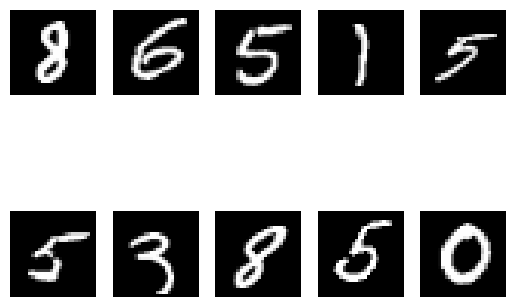

In [3]:
def imshow(img:th.Tensor, nrow: int = 5) -> None:
    img = img / 2 + 0.5
    npimg = img.numpy()
    batch_size = npimg.shape[0]
    ncol = int(np.ceil(batch_size/nrow))

    for i in range(batch_size):
        plt.subplot(nrow, ncol, i+1)
        plt.axis('off')
        plt.imshow(npimg[i], cmap='gray')
    plt.show()

dataiter = iter(loader_test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:10]), nrow = 2)

## System-of-systems formation

### 1. Companies

In [4]:
## Create Companies
n = 10
companies = []

for i in range(n):
    dt, distribution = dtManager.get_dataset()
    
    companies.append(
        Company("Company " + str(i+1), 
                dataset = dt,
                distribution = distribution,
                shared_model = Model().to(device),
                device = device,
                epochs=2,
        ))

sos = SoS(companies)
sos.vis_net.show(".rug_companies.html")

.rug_companies.html


Random binomial distribution of companies' dataset

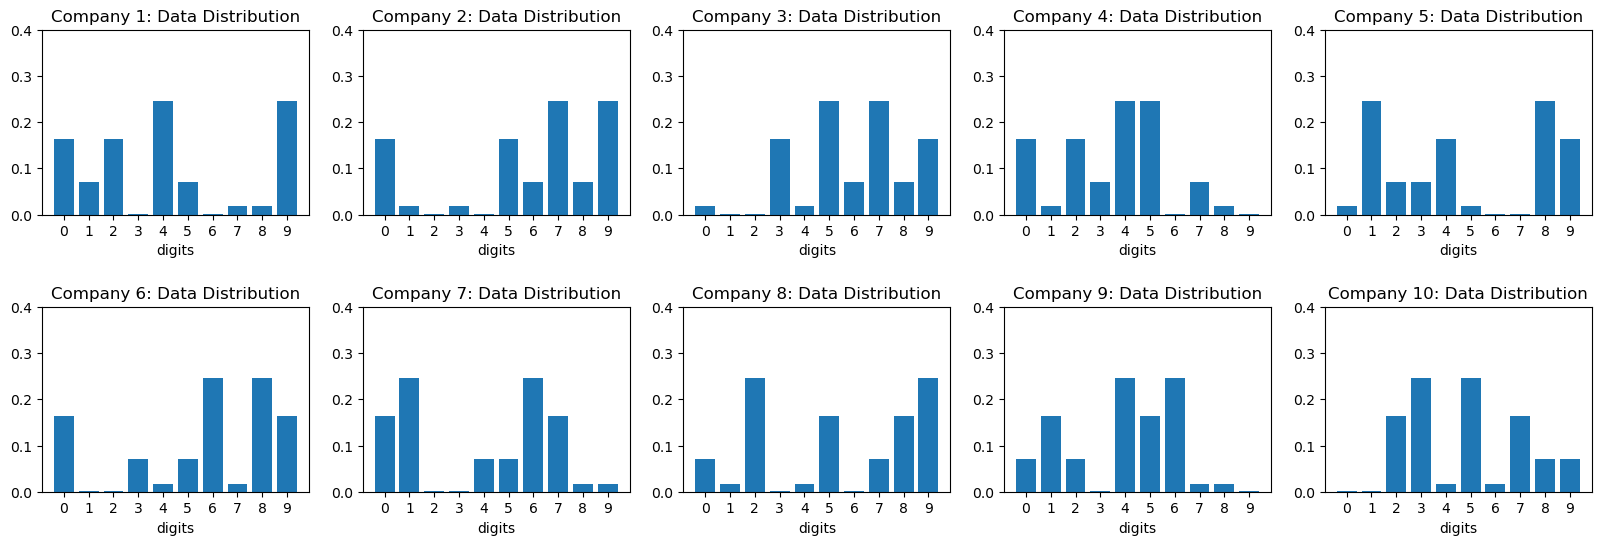

In [5]:

cnames = sos.get_names()
cdist = sos.get_distribution()

nrow = int(np.ceil(n/5))
fig, axs = plt.subplots(nrows=nrow, ncols=5, figsize=(4*5, 3*nrow))

for i in range(n):
    row = i // 5
    col = i % 5
    axs[row, col].bar(range(len(cdist[0])), cdist[i], tick_label=range(len(cdist[0])))
    axs[row, col].set_ylim([0, 0.4])
    axs[row, col].set_title(cnames[i] + ": Data Distribution")
    axs[row, col].set_xlabel("digits")

plt.subplots_adjust(hspace=0.5)
plt.show()

### 2. Partnership Formation

#### 2.A - Form partnership with most distinct companies (Hypothesis 1)

> Distinct data distribution between neighbors correlates with higher test accuracy

Discrete Data Distribution Likeness Score (D3LS):

$$
\textrm{D3LS}(d_i, d_j) = \| d_j - d_j \|^2 = (d_j - d_j)^T (d_i - d_j)
$$

where $d_i$ and $d_i$ are vectors describing company $i$ and company $j$ data distribution. Score of $0.0$ means perfect match, while $1.0$ means complete distinction. 

In [6]:
def most_distint_protocol(companies: Company) -> list:
    partners = []

    for company1 in companies:
        # for each company, compute D3 score with every other company
        scores = [d3ls(company1.distribution, company2.distribution).item() for company2 in companies]

        # select the 2 companies with most distint D3LS
        partners.append(np.argsort(scores, )[-2:].tolist())

    return partners

sos.set_partners(most_distint_protocol(sos.companies))

In [7]:
sos.vis_net.show(".rug_companies.html")

.rug_companies.html


### 3. Distributed Machine Learning (DML)

#### DML Cycle:
1. Independent training
2. Validation test with unseen data
2. Sharing of parameters

In [8]:
ncycle = 4
avg_validation = []

for cycle in range(ncycle):
    print(f"Cycle {cycle}: Started")

    # independent training
    sos.train()

    # validation test
    avg_validation.append(sos.avg_validate(loader_test))

    # merge neigbors' parameters
    sos.merge_parameters()

    print(f"Cycle {cycle}: Ended")

sos.train()
avg_validation.append(sos.avg_validate(loader_test))

Cycle 0: Started
Cycle 0: Ended
Cycle 1: Started
Cycle 1: Ended
Cycle 2: Started


In [ ]:
avg_validation

[0.025608070254325866]

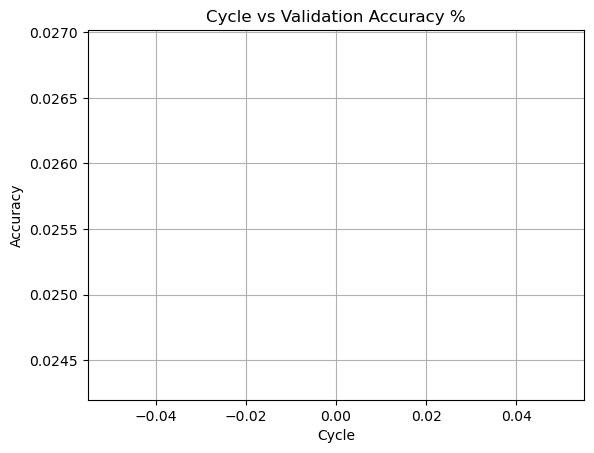

In [ ]:
# Validation plot

plt.plot(range(len(avg_validation)), avg_validation, 'g-')
plt.title("Cycle vs Validation Accuracy %")
plt.xlabel("Cycle")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

---

## Results

### Hypothesis 1
> Distinct data distribution between neighbors correlates with higher test accuracy

### V&V
> Vizualize trends in a scatter plot of average D3LS of edges vs average validation accuracy for different topology

In [ ]:
score = 0.0
for company in sos.companies:
        # for each company, compute D3 score with every other company
        score += sum([d3ls(company.distribution, sos.companies[i].distribution).item() for i in company.partners])

score /= sum([len(company.partners) for company in sos.companies])

print(f"Score = {score}")

Score = 0.025301406066864728
